# CSC2042S 2025 
## Assignment 3 

## Logistic Regression News Classification
#### Maryam Abrahams (ABRMAR043)
---

In [1]:
# imports and setup 
# !pip install torch
# !pip install datasets

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import numpy as np 
import random
import pandas as pd
import re
import string
import itertools
import seaborn as sns

from matplotlib.pyplot import imshow
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import vstack, csr_matrix
from sklearn.utils import resample
from IPython.display import display, Math, Latex

# Reproducibility setup
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## Task 1: Data Processing

In [2]:

# Loading datasets for both languages

def load(lang): #lang = xho or eng
    train = pd.read_csv(f"A3-dataset/{lang}/train.tsv", sep = "\t")
    dev = pd.read_csv(f"A3-dataset/{lang}/dev.tsv", sep = "\t")
    test = pd.read_csv(f"A3-dataset/{lang}/test.tsv", sep = "\t")
    return train, dev, test

english_train, english_dev, english_test = load("eng")
xhosa_train, xhosa_dev, xhosa_test = load("xho")

# Preprocessing texts: lower, punctuation, digits, spaces

def process_text(text):
    text = text.lower()
    text = re.sub(rf"[{string.punctuation}]", " ", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

def clean(df):
    text_col = "full_text" if "full_text" in df.columns else "text"
    df["clean_text"] = df[text_col].apply(process_text)
    return df

english_train, english_dev, english_test = map(clean, [english_train, english_dev, english_test])
xhosa_train, xhosa_dev, xhosa_test = map(clean, [xhosa_train, xhosa_dev, xhosa_test])

# Encoding labels for both languages 

eng_label_encoder = LabelEncoder()
y_eng_train = eng_label_encoder.fit_transform(english_train["category"])
y_eng_dev = eng_label_encoder.transform(english_dev["category"])
y_eng_test = eng_label_encoder.transform(english_test["category"])

xho_label_encoder = LabelEncoder()
y_xho_train = xho_label_encoder.fit_transform(xhosa_train["category"])
y_xho_dev = xho_label_encoder.transform(xhosa_dev["category"])
y_xho_test = xho_label_encoder.transform(xhosa_test["category"])

print(f"English classes: {eng_label_encoder.classes_}")
print(f"Xhosa classes: {xho_label_encoder.classes_}")


English classes: ['business' 'entertainment' 'health' 'politics' 'sports' 'technology']
Xhosa classes: ['business' 'entertainment' 'health' 'politics' 'sports']


## Task 2: Multinomial logistic regression implementation

In [3]:

# Multinomial logistic regression implementation

class MultinomialLogisticRegression(nn.Module):
    
    def __init__(self, input_size, num_classes):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, feature):
        output = self.linear(feature)
        return output

    def compute_probabilities(self, x): 
        output = self.forward(x)
        probs = F.softmax(output, dim=1)
        return probs

    def predict(self, x): 
        probs = self.compute_probabilities(x)
        predictions = torch.argmax(probs, dim = 1) 
        return predictions


## Task 5: Feature Extraction

In [4]:

# Feature Extraction

# Bag-of-Words (counts)
eng_count_vec = CountVectorizer(max_features=5000)
X_eng_train = eng_count_vec.fit_transform(english_train["clean_text"])
X_eng_dev   = eng_count_vec.transform(english_dev["clean_text"])
X_eng_test  = eng_count_vec.transform(english_test["clean_text"])
print('\nEnglish Vocabulary size:\n', len(eng_count_vec.get_feature_names_out()))

xho_count_vec = CountVectorizer(max_features=5000)
X_xho_train = xho_count_vec.fit_transform(xhosa_train["clean_text"])
X_xho_dev   = xho_count_vec.transform(xhosa_dev["clean_text"])
X_xho_test  = xho_count_vec.transform(xhosa_test["clean_text"])
print('Xhosa Vocabulary size:\n', len(xho_count_vec.get_feature_names_out()))

# Binary presence/absence
eng_bin_vec = CountVectorizer(binary=True, max_features=5000)
X_eng_train_bin = eng_bin_vec.fit_transform(english_train["clean_text"])
X_eng_dev_bin   = eng_bin_vec.transform(english_dev["clean_text"])
X_eng_test_bin  = eng_bin_vec.transform(english_test["clean_text"])

xho_bin_vec = CountVectorizer(binary=True, max_features=5000)
X_xho_train_bin = xho_bin_vec.fit_transform(xhosa_train["clean_text"])
X_xho_dev_bin   = xho_bin_vec.transform(xhosa_dev["clean_text"])
X_xho_test_bin  = xho_bin_vec.transform(xhosa_test["clean_text"])

# TF-IDF - astaggies
eng_tfidf_vec = TfidfVectorizer(max_features=5000)
X_eng_train_tfidf = eng_tfidf_vec.fit_transform(english_train["clean_text"])
X_eng_dev_tfidf   = eng_tfidf_vec.transform(english_dev["clean_text"])
X_eng_test_tfidf  = eng_tfidf_vec.transform(english_test["clean_text"])
print("\nSample TF-IDF row (rounded):\n", X_eng_train_tfidf.toarray()[0].round(2))

xho_tfidf_vec = TfidfVectorizer(max_features=5000)
X_xho_train_tfidf = xho_tfidf_vec.fit_transform(xhosa_train["clean_text"])
X_xho_dev_tfidf   = xho_tfidf_vec.transform(xhosa_dev["clean_text"])
X_xho_test_tfidf  = xho_tfidf_vec.transform(xhosa_test["clean_text"])
print("\nSample TF-IDF row (rounded):\n", X_xho_train_tfidf.toarray()[0].round(2))
print()



English Vocabulary size:
 5000
Xhosa Vocabulary size:
 5000

Sample TF-IDF row (rounded):
 [0. 0. 0. ... 0. 0. 0.]

Sample TF-IDF row (rounded):
 [0. 0. 0. ... 0. 0. 0.]



## Task 4: Hyperparameter tuning

In [5]:

# Hyperparameter tuning: 

X_train = X_eng_train_tfidf 
y_train = y_eng_train
X_dev = X_eng_dev_tfidf
y_dev = y_eng_dev

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

print(f"\nTuning for: English with TF-IDF")
print(f"Input dimension: {input_dim}")
print(f"Number of classes: {num_classes}")
print()

lrs = [0.01, 0.05, 0.1]
batch_sizes = [16, 32, 64]
best_val_acc = 0
best_params = {}

for lr, batch_size in itertools.product(lrs, batch_sizes):
    print(f"Testing lr={lr}, batch_size={batch_size}...", end=" ")
    
    # Convert to tensors INSIDE the loop (using the data defined above)
    X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_dev_tensor = torch.tensor(X_dev.toarray(), dtype=torch.float32)
    y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = MultinomialLogisticRegression(input_dim, num_classes)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Small quick training loop (3-5 epochs for tuning)
    for epoch in range(5):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model.forward(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        preds = model.predict(X_dev_tensor)
        val_acc = (preds == y_dev_tensor).float().mean().item()
    
    print(f"Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = {"lr": lr, "batch_size": batch_size}

print("\n" + "="*50)
print("Best params:", best_params)
print("Best validation accuracy:", best_val_acc)
print("="*50)
print()



Tuning for: English with TF-IDF
Input dimension: 5000
Number of classes: 6

Testing lr=0.01, batch_size=16... Val Acc: 0.2119
Testing lr=0.01, batch_size=32... Val Acc: 0.2119
Testing lr=0.01, batch_size=64... Val Acc: 0.2119
Testing lr=0.05, batch_size=16... Val Acc: 0.5699
Testing lr=0.05, batch_size=32... Val Acc: 0.3941
Testing lr=0.05, batch_size=64... Val Acc: 0.2182
Testing lr=0.1, batch_size=16... Val Acc: 0.7648
Testing lr=0.1, batch_size=32... Val Acc: 0.5148
Testing lr=0.1, batch_size=64... Val Acc: 0.4025

Best params: {'lr': 0.1, 'batch_size': 16}
Best validation accuracy: 0.7648305296897888



## Task 3: Training 

In [6]:

# Training 

def train_model(model, X_train, y_train, X_val, y_val, 
                learning_rate=0.1, batch_size=32, max_epochs=100, 
                patience=5, verbose=True):
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Training history tracking
    history = {
        'train_loss': [],
        'val_accuracy': [],
        'best_val_accuracy': 0,
        'best_epoch': 0
    }
    
    best_val_acc = 0
    patience_counter = 0
    best_model_state = None
    
    if verbose:
        print(f"Starting training for {max_epochs} epochs with patience {patience}")
        print(f"Initial validation accuracy: ", end="")
    
    # Training loop
    for epoch in range(max_epochs):
        model.train()  
        epoch_loss = 0
        num_batches = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
        
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_train_loss)
        
        model.eval()
        with torch.no_grad():
            val_predictions = model.predict(X_val_tensor)
            val_accuracy = (val_predictions == y_val_tensor).float().mean().item()
            history['val_accuracy'].append(val_accuracy)
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            history['best_val_accuracy'] = best_val_acc
            history['best_epoch'] = epoch
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if verbose and (epoch % 10 == 0 or epoch == max_epochs - 1 or patience_counter == 0):
            print(f"Epoch {epoch:3d}: Train Loss = {avg_train_loss:.4f}, "
                  f"Val Acc = {val_accuracy:.4f}, Best = {best_val_acc:.4f}")

        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}. No improvement for {patience} epochs.")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    if verbose:
        print(f"Training completed. Best validation accuracy: {best_val_acc:.4f} "
              f"at epoch {history['best_epoch']}")
    
    return history


In [7]:

# Training with best hyperparameters

def demonstrate_training():

    print("\nDEMONSTRATING TRAINING LOOP")
    print("=" * 60)
    
    best_lr = best_params["lr"]
    best_batch_size = best_params["batch_size"]
    
    print(f"Using best parameters: lr={best_lr}, batch_size={best_batch_size}")
    
    model = MultinomialLogisticRegression(input_dim, num_classes)
    
    # early stopping
    history = train_model(
        model=model,
        X_train=X_eng_train_tfidf,
        y_train=y_eng_train,
        X_val=X_eng_dev_tfidf, 
        y_val=y_eng_dev,
        learning_rate=best_lr,
        batch_size=best_batch_size,
        max_epochs=100,
        patience=5,
        verbose=True
    )
    
    return model, history

trained_model, training_history = demonstrate_training()
print()



DEMONSTRATING TRAINING LOOP
Using best parameters: lr=0.1, batch_size=16
Starting training for 100 epochs with patience 5
Initial validation accuracy: Epoch   0: Train Loss = 1.7422, Val Acc = 0.2246, Best = 0.2246
Epoch   1: Train Loss = 1.6571, Val Acc = 0.4958, Best = 0.4958
Epoch   2: Train Loss = 1.5786, Val Acc = 0.5699, Best = 0.5699
Epoch   3: Train Loss = 1.5065, Val Acc = 0.6801, Best = 0.6801
Epoch   4: Train Loss = 1.4402, Val Acc = 0.7648, Best = 0.7648
Epoch   6: Train Loss = 1.3230, Val Acc = 0.8093, Best = 0.8093
Epoch   7: Train Loss = 1.2726, Val Acc = 0.8178, Best = 0.8178
Epoch   9: Train Loss = 1.1819, Val Acc = 0.8199, Best = 0.8199
Epoch  10: Train Loss = 1.1413, Val Acc = 0.8305, Best = 0.8305
Epoch  11: Train Loss = 1.1045, Val Acc = 0.8326, Best = 0.8326
Epoch  12: Train Loss = 1.0703, Val Acc = 0.8390, Best = 0.8390
Epoch  13: Train Loss = 1.0383, Val Acc = 0.8453, Best = 0.8453
Epoch  16: Train Loss = 0.9558, Val Acc = 0.8496, Best = 0.8496
Epoch  19: Train

<Figure size 1000x400 with 0 Axes>

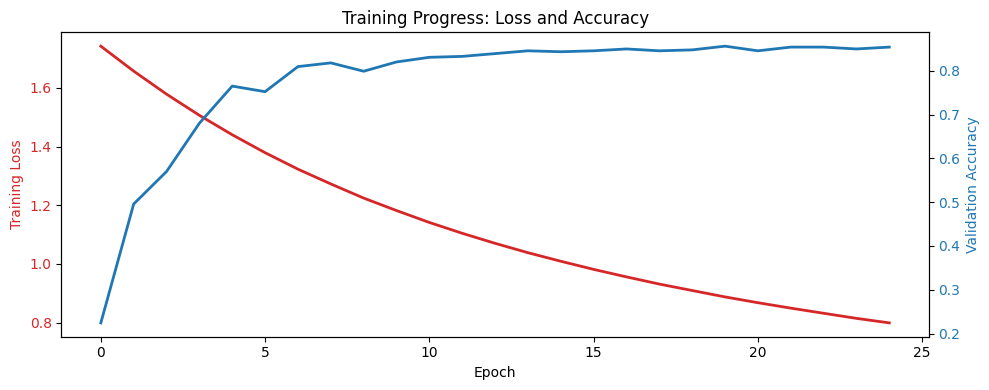

In [8]:

# Plotting training history 

def simple_training_plot(history):
    
    plt.figure(figsize=(10, 4))
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(history['train_loss'], color=color, linewidth=2, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Accuracy', color=color)
    ax2.plot(history['val_accuracy'], color=color, linewidth=2, label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('Training Progress: Loss and Accuracy')
    fig.tight_layout()
    plt.show()

simple_training_plot(training_history)


## Task 6: isiXhosa training decisions

In [9]:

# Helper function

def quick_train(X_train, y_train, X_val, y_val, weight_decay=0.0):
    X_train_t = torch.tensor(X_train.toarray(), dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t = torch.tensor(X_val.toarray(), dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.long)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
    
    model = MultinomialLogisticRegression(X_train.shape[1], len(np.unique(y_train)))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(20):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        preds = model.predict(X_val_t)
        return (preds == y_val_t).float().mean().item()

In [10]:
# Training data

torch.manual_seed(42)
np.random.seed(42)

input_dim = X_xho_train_tfidf.shape[1]
num_classes = len(xho_label_encoder.classes_)

print("\n" + "="*60)
print("TASK 6: ISIXHOSA TRAINING DECISIONS")
print("="*60)

print("\n1. BASELINE")
baseline_acc = quick_train(X_xho_train_tfidf, y_xho_train, X_xho_dev_tfidf, y_xho_dev)
print(f"   Validation Accuracy: {baseline_acc:.4f}")

print("\n2. L2 REGULARIZATION")
l2_results = {}
for wd in [0.001, 0.01, 0.1]:
    acc = quick_train(X_xho_train_tfidf, y_xho_train, X_xho_dev_tfidf, y_xho_dev, weight_decay=wd)
    l2_results[wd] = acc
    print(f"   weight_decay={wd:.3f}: {acc:.4f}")
best_l2_wd = max(l2_results, key=l2_results.get)
best_l2_acc = l2_results[best_l2_wd]
print(f"   Best: weight_decay={best_l2_wd:.3f}, Acc={best_l2_acc:.4f}")


print("\n3. L1 REGULARIZATION")

def train_with_l1(X_train, y_train, X_val, y_val, l1_lambda):
    X_train_t = torch.tensor(X_train.toarray(), dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t = torch.tensor(X_val.toarray(), dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.long)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
    model = MultinomialLogisticRegression(X_train.shape[1], len(np.unique(y_train)))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(20):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            # Add L1 penalty
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_penalty
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        preds = model.predict(X_val_t)
        return (preds == y_val_t).float().mean().item()

l1_results = {}
for l1 in [0.0001, 0.001, 0.01]:
    acc = train_with_l1(X_xho_train_tfidf, y_xho_train, X_xho_dev_tfidf, y_xho_dev, l1)
    l1_results[l1] = acc
    print(f"   lambda={l1:.4f}: {acc:.4f}")

best_l1_lambda = max(l1_results, key=l1_results.get)
best_l1_acc = l1_results[best_l1_lambda]
print(f"   Best: lambda={best_l1_lambda:.4f}, Acc={best_l1_acc:.4f}")


print("\n4. UPSAMPLING")
print("   Original distribution:", dict(zip(*np.unique(y_xho_train, return_counts=True))))
max_count = max(np.sum(y_xho_train == c) for c in np.unique(y_xho_train))
X_list, y_list = [], []
for c in np.unique(y_xho_train):
    X_c = X_xho_train_tfidf[y_xho_train == c].toarray()
    y_c = y_xho_train[y_xho_train == c]
    X_up, y_up = resample(X_c, y_c, n_samples=max_count, random_state=42)
    X_list.append(csr_matrix(X_up))
    y_list.append(y_up)
X_upsampled = vstack(X_list)
y_upsampled = np.concatenate(y_list)
print("   Upsampled distribution:", dict(zip(*np.unique(y_upsampled, return_counts=True))))

up_acc = quick_train(X_upsampled, y_upsampled, X_xho_dev_tfidf, y_xho_dev)
print(f"   Validation Accuracy: {up_acc:.4f}")

print("\n5. DOWNSAMPLING")
min_count = min(np.sum(y_xho_train == c) for c in np.unique(y_xho_train))
X_list, y_list = [], []
for c in np.unique(y_xho_train):
    X_c = X_xho_train_tfidf[y_xho_train == c].toarray()
    y_c = y_xho_train[y_xho_train == c]
    X_down, y_down = resample(X_c, y_c, n_samples=min_count, random_state=42, replace=False)
    X_list.append(csr_matrix(X_down))
    y_list.append(y_down)

X_downsampled = vstack(X_list)
y_downsampled = np.concatenate(y_list)
print("   Downsampled distribution:", dict(zip(*np.unique(y_downsampled, return_counts=True))))

down_acc = quick_train(X_downsampled, y_downsampled, X_xho_dev_tfidf, y_xho_dev)
print(f"   Validation Accuracy: {down_acc:.4f}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Baseline:           {baseline_acc:.4f}")
print(f"Best L2:            {best_l2_acc:.4f} ( {best_l2_acc-baseline_acc:+.4f})")
print(f"Best L1:            {best_l1_acc:.4f} ( {best_l1_acc-baseline_acc:+.4f})")
print(f"Upsampling:         {up_acc:.4f} ( {up_acc-baseline_acc:+.4f})")
print(f"Downsampling:       {down_acc:.4f} ( {down_acc-baseline_acc:+.4f})")

best_technique = max([
    ('Baseline', baseline_acc),
    ('L2', best_l2_acc),
    ('L1', best_l1_acc),
    ('Upsampling', up_acc),
    ('Downsampling', down_acc)
], key=lambda x: x[1])

print(f"\nBest technique: {best_technique[0]} with {best_technique[1]:.4f}")
print("="*60)


TASK 6: ISIXHOSA TRAINING DECISIONS

1. BASELINE
   Validation Accuracy: 0.6463

2. L2 REGULARIZATION
   weight_decay=0.001: 0.6599
   weight_decay=0.010: 0.6599
   weight_decay=0.100: 0.6599
   Best: weight_decay=0.001, Acc=0.6599

3. L1 REGULARIZATION
   lambda=0.0001: 0.6599
   lambda=0.0010: 0.6190
   lambda=0.0100: 0.3605
   Best: lambda=0.0001, Acc=0.6599

4. UPSAMPLING
   Original distribution: {np.int64(0): np.int64(50), np.int64(1): np.int64(350), np.int64(2): np.int64(70), np.int64(3): np.int64(215), np.int64(4): np.int64(347)}
   Upsampled distribution: {np.int64(0): np.int64(350), np.int64(1): np.int64(350), np.int64(2): np.int64(350), np.int64(3): np.int64(350), np.int64(4): np.int64(350)}
   Validation Accuracy: 0.8707

5. DOWNSAMPLING
   Downsampled distribution: {np.int64(0): np.int64(50), np.int64(1): np.int64(50), np.int64(2): np.int64(50), np.int64(3): np.int64(50), np.int64(4): np.int64(50)}
   Validation Accuracy: 0.7891

SUMMARY
Baseline:           0.6463
Best L2

## Task 7: Evaluation

In [ ]:

# Train final English model
print("\nTraining final English model...")
final_eng_model = MultinomialLogisticRegression(5000, 6)
eng_history = train_model(
    model=final_eng_model,
    X_train=X_eng_train_tfidf,
    y_train=y_eng_train,
    X_val=X_eng_dev_tfidf,
    y_val=y_eng_dev,
    learning_rate=0.1,
    batch_size=16,
    max_epochs=100,
    patience=5,
    verbose=True
)

# Train final Xhosa model 
print("\nTraining final Xhosa model with upsampling...")
final_xho_model = MultinomialLogisticRegression(5000, 5)
xho_history = train_model(
    model=final_xho_model,
    X_train=X_upsampled,
    y_train=y_upsampled,
    X_val=X_xho_dev_tfidf,
    y_val=y_xho_dev,
    learning_rate=0.05,
    batch_size=32,
    max_epochs=100,
    patience=5,
    verbose=True
)

print()



Training final English model...
Starting training for 100 epochs with patience 5
Initial validation accuracy: Epoch   0: Train Loss = 1.7439, Val Acc = 0.3475, Best = 0.3475
Epoch   1: Train Loss = 1.6573, Val Acc = 0.5085, Best = 0.5085
Epoch   2: Train Loss = 1.5789, Val Acc = 0.5869, Best = 0.5869
Epoch   3: Train Loss = 1.5072, Val Acc = 0.7140, Best = 0.7140
Epoch   4: Train Loss = 1.4403, Val Acc = 0.7691, Best = 0.7691
Epoch   5: Train Loss = 1.3798, Val Acc = 0.7945, Best = 0.7945
Epoch   6: Train Loss = 1.3241, Val Acc = 0.7966, Best = 0.7966
Epoch   8: Train Loss = 1.2254, Val Acc = 0.8284, Best = 0.8284
Epoch   9: Train Loss = 1.1820, Val Acc = 0.8326, Best = 0.8326
Epoch  10: Train Loss = 1.1417, Val Acc = 0.8347, Best = 0.8347
Epoch  13: Train Loss = 1.0393, Val Acc = 0.8453, Best = 0.8453
Epoch  15: Train Loss = 0.9817, Val Acc = 0.8559, Best = 0.8559


In [ ]:

def evaluation(model, X_test, y_test, class_names, language_name):

    # predictions
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        y_pred = model.predict(X_test_tensor).numpy()
    
    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # results
    print(f"\n{language_name} Evaluation:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: Micro={precision_micro:.4f}, Macro={precision_macro:.4f}")
    print(f"Recall:    Micro={recall_micro:.4f}, Macro={recall_macro:.4f}") 
    print(f"F1-Score:  Micro={f1_micro:.4f}, Macro={f1_macro:.4f}")
    
    # Micro vs Macro analysis
    micro_macro_diff = f1_micro - f1_macro
    if micro_macro_diff > 0.1:
        print(f"→ Macro F1 is {micro_macro_diff:.3f} lower than Micro F1: dataset is imbalanced")
    else:
        print("→ Micro and Macro F1 are similar: classes are relatively balanced")
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{language_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # best/worst
    best_class = class_names[np.argmax(np.diag(cm))]
    worst_class = class_names[np.argmin(np.diag(cm))]
    print(f"Most reliable: {best_class} ({np.max(np.diag(cm))} correct)")
    print(f"Least reliable: {worst_class} ({np.min(np.diag(cm))} correct)")
    
    return y_pred


print("=" * 50)
print("TASK 7: MODEL EVALUATION")
print("=" * 50)

# English
eng_predictions = evaluation(
    final_eng_model, 
    X_eng_test_tfidf, 
    y_eng_test,
    eng_label_encoder.classes_, 
    "English"
)

# Xhosa
xho_predictions = evaluation(
    final_xho_model,
    X_xho_test_tfidf,
    y_xho_test,
    xho_label_encoder.classes_,
    "isiXhosa" 
)


## Task 8: Weight Analysis

In [ ]:

# Weight analysis
print("TASK 8: WEIGHT ANALYSIS")

weights = final_eng_model.linear.weight.detach().numpy()
vocabulary = eng_tfidf_vec.get_feature_names_out()
class_names = eng_label_encoder.classes_

print("\nTOP WORDS FOR EACH CATEGORY:")
for class_idx, class_name in enumerate(class_names):
    class_weights = weights[class_idx]
    top_indices = np.argsort(class_weights)[-10:][::-1]  # Top 10 words
    top_words = [vocabulary[i] for i in top_indices]
    print(f"\n{class_name.upper()}: {', '.join(top_words)}")
print()


In [ ]:

# Plotting weight analysis

plt.figure(figsize=(12, 8))
top_words_matrix = []
weight_matrix = []

for class_idx, class_name in enumerate(class_names):
    class_weights = weights[class_idx]
    top_indices = np.argsort(class_weights)[-8:][::-1]  # Top 8 words
    top_words = [vocabulary[i] for i in top_indices]
    top_weights = [class_weights[i] for i in top_indices]
    
    top_words_matrix.append(top_words)
    weight_matrix.append(top_weights)
    
weight_array = np.array(weight_matrix)


sns.heatmap(weight_array, 
            annot=top_words_matrix,  # Show words as annotations
            fmt='',
            xticklabels=['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th'],
            yticklabels=class_names,
            cmap='coolwarm', 
            center=0)       
plt.title("Weight Values for Top 8 Words in Each Category")
plt.tight_layout()
plt.show()
